### Importing libraries

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

input_path = "../input/cat-and-dog/" 

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'training_set/training_set', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'test_set/test_set', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

### Selecting GPU if available

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### Training

In [10]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.1005, acc: 0.9629
Epoch 2/3
----------
train loss: 0.0785, acc: 0.9685
Epoch 3/3
----------
train loss: 0.0605, acc: 0.9759


In [12]:
!mkdir models
!mkdir models/pytorch

In [13]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

### Modifying last layer

In [14]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))



<All keys matched successfully>

### Showing some sample images

In [15]:
validation_img_paths = ["test_set/test_set/cats/cat.4001.jpg",
                        "test_set/test_set/cats/cat.4003.jpg",
                        "test_set/test_set/dogs/dog.4004.jpg",
                       "test_set/test_set/dogs/dog.4006.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [16]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [17]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 3.4506, -4.0686],
        [ 4.8924, -5.7091],
        [-3.4927,  3.3217],
        [-3.5797,  3.0487]], device='cuda:0', grad_fn=<AddmmBackward>)

In [18]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9945778e-01, 5.4227392e-04],
       [9.9997509e-01, 2.4878718e-05],
       [1.0966846e-03, 9.9890327e-01],
       [1.3204305e-03, 9.9867958e-01]], dtype=float32)

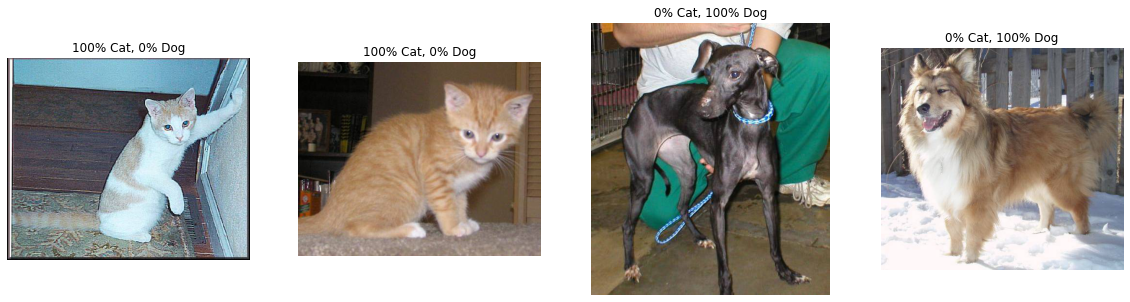

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

### Confusion Matrix

In [20]:
labels_input=[]
labels_output=[]
def test_model(model, criterion, optimizer, num_epochs=1):
    for phase in ['validation']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input.append(labels)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output.append(preds)
            
            
test_model(model, criterion, optimizer, num_epochs=1)

In [21]:
y_pred=(torch.cat(labels_output))
y_pred=y_pred.cpu().numpy()


y_true=(torch.cat(labels_input))
y_true=y_true.cpu().numpy()


from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[1008,    3],
       [  36,  976]])